In [1]:
import pandas as pd
from fastai import *
from fastai.tabular import *
import seaborn as sb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve

In [2]:
path = "data/reduced-aggregated.csv"
model_path = 'model/'
dtype = dict(MONTH=np.int32, DAY_OF_WEEK=np.int32, FL_NUM=np.int32)
df = pd.read_csv(path, dtype=dtype)

In [3]:
df.head()

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
0,2,5,2017-02-03,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
1,2,7,2017-02-12,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN
2,2,1,2017-02-13,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN
3,2,1,2017-02-27,B6,33,DCA,"Washington, DC",PBI,"West Palm Beach/Palm Beach, FL",1730.0,0.0,157.0,857.0,NaN
4,2,2,2017-02-14,B6,34,JFK,"New York, NY",BTV,"Burlington, VT",1706.0,0.0,81.0,266.0,NaN


# Exploratory Analysis

Out of 12 feature columns, 10 are categorical and 2 are continuous
Seeing many columns have a large number of unique data, ranging from 7 to 6774 unique values.
One-hot encoding all of these columns will result into over 1 thousand columns of sparse information,
which is not an ideal situation for training. Instead, we will create embeddings on the categorical data.

### Feature extraction
Some features can be extracted from the existing columns

* FL_DATE
    * YEAR: Extract the year
    * WEEK: Extract the nth week of the month
* CRS_DEP_TIME: Time is in 24hour format, we extract the hour and closest 15th minute
    * DEP_HOUR: Get the departure hour
    * DEP_MIN15: Get the nearest floor of 15th minute 

### Embedding: 
Since date/time, carrier and departure/arrival destination information are categorical data, we would need change so that the values can be used for training. For this purpose, we can change the categorical values into different embeddings.
* YEAR
* WEEK
* MONTH
* DAY_OF_WEEK
* UNIQUE_CARRIER
* ORIGIN
* ORIGIN_CITY_NAME
* DEST
* DEST_CITY_NAME
* DEP_HOUR
* DEP_MIN15

### Dont change: 
These two colums are continous data that don't have to be altered; except for normalization
* DISTANCE
* CRS_ELAPSED_TIME


In [4]:
df.drop(columns=["CRS_DEP_TIME", "DISTANCE", "Unnamed: 13"]).nunique()

MONTH                 11
DAY_OF_WEEK            7
FL_DATE              334
UNIQUE_CARRIER        12
FL_NUM              6774
ORIGIN               309
ORIGIN_CITY_NAME     305
DEST                 310
DEST_CITY_NAME       306
ARR_DEL15              2
CRS_ELAPSED_TIME     546
dtype: int64

In [5]:
def clean_data(df): 
    drop_columns = ['Unnamed: 13', 'CRS_DEP_TIME', 'FL_DATE', 'CRS_DEP_TIME']

    df["YEAR"] = df.apply(lambda row: int(row.FL_DATE.split('-')[0]), axis=1)
    df["WEEK"] = df.apply(lambda row: int(row.FL_DATE.split('-')[2]) // 6, axis=1)
    df["DEP_HOUR"] = df.apply(lambda row: row.CRS_DEP_TIME // 100, axis=1)
    df["DEP_MIN15"] = df.apply(lambda row: (row.CRS_DEP_TIME % 100) // 15, axis=1)

    df = df.drop(columns=drop_columns)
    df = df.fillna(0)
    df = df.astype({"ARR_DEL15": np.long})

    return df

In [6]:
df = clean_data(df)

In [7]:
df.isna().any()

MONTH               False
DAY_OF_WEEK         False
UNIQUE_CARRIER      False
FL_NUM              False
ORIGIN              False
ORIGIN_CITY_NAME    False
DEST                False
DEST_CITY_NAME      False
ARR_DEL15           False
CRS_ELAPSED_TIME    False
DISTANCE            False
YEAR                False
WEEK                False
DEP_HOUR            False
DEP_MIN15           False
dtype: bool

## Total delays

101365 of 570274 delayed and it is the 17.77% of data.
468909 of 570274 not delayed and it is the 82.23% of the data.


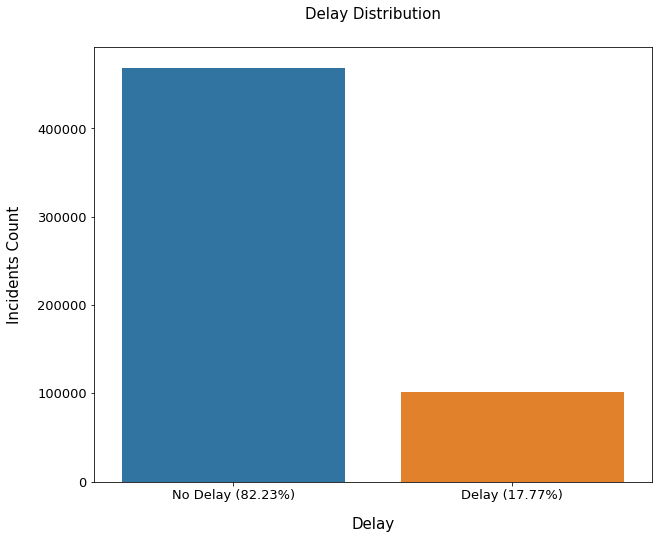

In [8]:
delay = df['ARR_DEL15'].value_counts()[1]
no_delay = df['ARR_DEL15'].value_counts()[0]
delay_percentage = delay / df.shape[0] * 100
no_delay_percentage = no_delay / df.shape[0] * 100

print('{} of {} delayed and it is the {:.2f}% of data.'.format(delay, df.shape[0], delay_percentage))
print('{} of {} not delayed and it is the {:.2f}% of the data.'.format(no_delay, df.shape[0], no_delay_percentage))

plt.figure(figsize=(10, 8))
sb.countplot(df['ARR_DEL15'])

plt.xlabel('Delay', size=15, labelpad=15)
plt.ylabel('Incidents Count', size=15, labelpad=15)
plt.xticks((0, 1), ['No Delay ({0:.2f}%)'.format(no_delay_percentage), 'Delay ({0:.2f}%)'.format(delay_percentage)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Delay Distribution', size=15, y=1.05)

plt.show()

## Handling the data
* Continuous variables (CRS_ELEAPSED_TIME and DISTANCE) are normalized
* Categorical values are created into embedding matrices, per fastai docs: min(600, round(1.6 * n_cat**0.56)))
* Missing values are filled with medians

In [9]:
dep_var = "ARR_DEL15"
cat_names = ["MONTH", "DAY_OF_WEEK", "UNIQUE_CARRIER", "FL_NUM", "ORIGIN",
             "DEST", "DEP_HOUR", "DEP_MIN15", "YEAR", "WEEK"]
cont_names = ["CRS_ELAPSED_TIME", "DISTANCE"]
dep_var = "ARR_DEL15"
procs = [FillMissing, Categorify, Normalize]

In [10]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
train_idx = []
test_idx = []
for train_index, test_index in cv.split(df):
    train_idx.append(train_index)
    test_idx.append(test_index)

In [11]:
test = TabularList.from_df(df.iloc[test_idx[0]].copy(), path=model_path, cat_names=cat_names, cont_names=cont_names)
data = (TabularList.from_df(df, path=model_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(test_idx[0])
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())

In [12]:
len(test_idx[0])

57028

In [13]:
data.test_ds

LabelList (57028 items)
x: TabularList
MONTH 2; DAY_OF_WEEK 1; UNIQUE_CARRIER B6; FL_NUM 33; ORIGIN BTV; DEST JFK; DEP_HOUR 19.0; DEP_MIN15 0.0; YEAR 2017; WEEK 2; CRS_ELAPSED_TIME -0.7267; DISTANCE -0.9420; ,MONTH 2; DAY_OF_WEEK 6; UNIQUE_CARRIER B6; FL_NUM 34; ORIGIN PBI; DEST DCA; DEP_HOUR 20.0; DEP_MIN15 3.0; YEAR 2017; WEEK 3; CRS_ELAPSED_TIME -0.1647; DISTANCE 0.0088; ,MONTH 2; DAY_OF_WEEK 1; UNIQUE_CARRIER B6; FL_NUM 34; ORIGIN PBI; DEST DCA; DEP_HOUR 20.0; DEP_MIN15 3.0; YEAR 2017; WEEK 4; CRS_ELAPSED_TIME -0.1647; DISTANCE 0.0088; ,MONTH 2; DAY_OF_WEEK 2; UNIQUE_CARRIER B6; FL_NUM 49; ORIGIN BOS; DEST SAV; DEP_HOUR 10.0; DEP_MIN15 0.0; YEAR 2017; WEEK 4; CRS_ELAPSED_TIME 0.3059; DISTANCE 0.0796; ,MONTH 2; DAY_OF_WEEK 5; UNIQUE_CARRIER B6; FL_NUM 54; ORIGIN PBI; DEST JFK; DEP_HOUR 19.0; DEP_MIN15 0.0; YEAR 2017; WEEK 2; CRS_ELAPSED_TIME 0.2406; DISTANCE 0.2839; 
y: CategoryList
0,0,0,0,0
Path: model

## Handling imbalanced Data
We can see from the distribution that delayed flights are 17.77% of data, and not-delayed are 82.23%.
Testing with smote has greatly decreased the accuracy and precision/recall of the data.
Instead, we use class weighting on the CrossEntropyLoss to the inverse of each classess' distribution.
Furthermore, since we want to be more accurate in predicting flights that could be delayed,
we take a closer look into precision and recall, as opposed to general accuracy.


## Training
For training, we find the best learning rate using the lr_find() function. This function searches for the best **LR** value by training the model with increasing lr values and getting the loss for each rate.
Looking at the lr plot, we can choose 5e-3, which is well below the exponential increase of the loss.
Furthermore, the training is done through fit_one_cycle, where the lr changes in a cosine-annealing, with max lr reachin 5e-3. 
The training is limited to 2 epochs, since starting the 3rd epoch, there is overfitting (lower train_loss but increase in validation_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


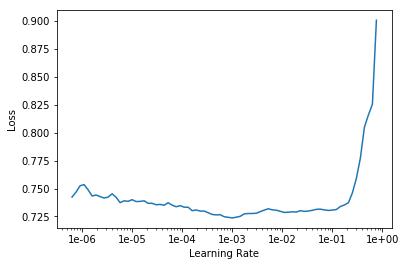

In [14]:
prec = Precision()
recall = Recall()
learn = tabular_learner(data, layers=[200,100,100], metrics=[accuracy, prec, recall], emb_drop=0.2, ps=[0., 0.2, 0.2])
learn.loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.18, 0.82]))
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2, max_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.654893,0.644129,0.651382,0.274075,0.594899,02:53
1,0.641249,0.637810,0.659658,0.282148,0.604663,03:03


## Model Structure
learn = tabular_learner(data, layers=[200,100,100], metrics=[accuracy, prec, recall], emb_drop=0.2, ps=[0., 0.2, 0.2])
The model structure is largely comprised of the embeddings of the categories with 0.2 dropout, 3 linear layers of size (200, 100, 100) with dropout [0, 0.2, 0.2], respectively.

In [16]:
learn.model.embeds # example of embedding on one k-fold data

ModuleList(
  (0): Embedding(12, 6)
  (1): Embedding(8, 5)
  (2): Embedding(13, 7)
  (3): Embedding(6748, 223)
  (4): Embedding(310, 40)
  (5): Embedding(311, 40)
  (6): Embedding(25, 10)
  (7): Embedding(5, 4)
  (8): Embedding(3, 3)
  (9): Embedding(7, 5)
)

In [17]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [6]                  72         True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [7]                  91         True      
______________________________________________________________________
Embedding            [223]                1,504,804  True      
______________________________________________________________________
Embedding            [40]                 12,400     True      
______________________________________________________________________
Embedding            [40]                 12,440     True      
______________________________________________________________________
Embedding            [10]                 250        True      
______________________________________________________________

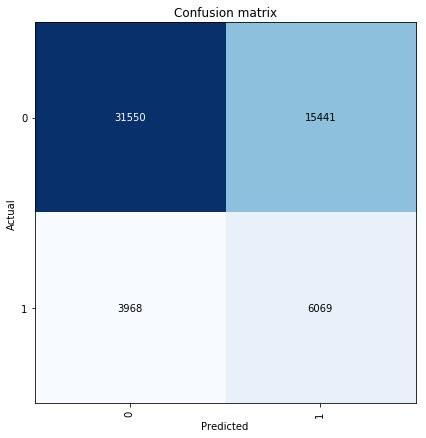

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
a=interp.plot_confusion_matrix(figsize=(6,6), return_fig=True)

In [19]:
data.show_batch(rows=10)

MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,DEP_HOUR,DEP_MIN15,YEAR,WEEK,CRS_ELAPSED_TIME,DISTANCE,target
2,4,WN,526,DEN,OKC,19.0,2.0,2017,3,-0.7921,-0.5736,1
7,5,WN,2518,RDU,MDW,8.0,1.0,2016,4,-0.3999,-0.3532,0
4,5,OO,4847,SBN,MSP,7.0,1.0,2016,4,-0.3084,-0.7087,0
10,2,WN,269,CMH,MDW,18.0,2.0,2016,0,-0.9228,-0.9146,0
6,7,WN,3384,MCO,ROC,10.0,0.0,2016,4,0.1229,0.2920,1
6,5,DL,1440,SLC,MSP,5.0,3.0,2016,2,-0.0078,0.2244,0
1,1,WN,4074,SJC,BUR,9.0,0.0,2017,0,-1.1189,-0.8937,0
11,7,F9,668,SFO,DEN,18.0,3.0,2016,2,0.0706,0.1858,0
1,5,DL,2068,DCA,MSP,17.0,1.0,2017,3,0.4497,0.1279,0
7,2,UA,564,LAX,ORD,22.0,3.0,2016,4,1.2340,1.4358,1


In [20]:
preds = learn.get_preds()[1].tolist()
actual = df.iloc[test_idx[0]].ARR_DEL15.values

In [21]:
df1 = df.rename(columns={'CRS_ELAPSED_TIME': 'target'})

In [22]:
df1.head()

,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,ARR_DEL15,target,DISTANCE,YEAR,WEEK,DEP_HOUR,DEP_MIN15
0,2,5,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",0,90.0,266.0,2017,0,19.0,0.0
1,2,7,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1,90.0,266.0,2017,2,19.0,0.0
2,2,1,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1,90.0,266.0,2017,2,19.0,0.0
3,2,1,B6,33,DCA,"Washington, DC",PBI,"West Palm Beach/Palm Beach, FL",0,157.0,857.0,2017,4,17.0,2.0
4,2,2,B6,34,JFK,"New York, NY",BTV,"Burlington, VT",0,81.0,266.0,2017,2,17.0,0.0


In [23]:
test_dl = learn.data.test_dl

In [24]:
len(train_idx[0]), len(test_idx[0])

(513246, 57028)

In [25]:
len(preds), len(actual)

(57028, 57028)

In [26]:
learn.get_preds()

[tensor([[0.4888, 0.5112],
         [0.4893, 0.5107],
         [0.4528, 0.5472],
         ...,
         [0.6648, 0.3352],
         [0.6225, 0.3775],
         [0.7200, 0.2800]]), tensor([1, 0, 0,  ..., 0, 0, 0])]

In [ ]:
prec = Precision()
recall = Recall()
predictions = []
for i in range(len(train_idx)):
    test = TabularList.from_df(df.iloc[test_idx[i]].copy(), path=model_path, cat_names=cat_names, cont_names=cont_names)
    data = (TabularList.from_df(df, path=model_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(test_idx[i])
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())

    learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, prec, recall], emb_drop=0.2, ps=[0., 0.2])
    learn.loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.18, 0.82]))
    learn.fit_one_cycle(2, max_lr=5e-3)
    predictions.append(learn.get_preds()[1].tolist())

epoch,train_loss,valid_loss,accuracy,precision,recall,time
